In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from typing import NamedTuple
from dataclasses import dataclass
from enum import IntEnum
from typing import Callable
import hybrid

# Birth death extinction probability

In [4]:
seed = None
if seed is not None:
    rng = np.random.default_rng(seed)
else:
    rng = np.random.default_rng()

initial_pop = 10
y0 = np.array([10e10,initial_pop])

# births and deaths: we have an irrelevant birth/death process for a large scale species (to test that our system is well isolated)
# and a birth death process for a small-valued species
N = np.array([[1, -1,0,0],[0,0,1,-1]])
rate_involvement_matrix = np.array([[1, 1,0,0],[0,0,1,1]])

birth_rate = 11
death_rate = 10

def birth_death_rate_constants(t):
    return np.array([1.1, 1.0, birth_rate, death_rate])

extinctions = 0
for i in range(1000):
    result = hybrid.forward_time(y0, [0, 15.0], lambda p: hybrid.partition_by_threshold(p, 1000), birth_death_rate_constants, N, rate_involvement_matrix, rng, discontinuities=[4.0])
    extinctions += result.y[-1] == 0.0
    print("i", i, "Exctinctions:", extinctions, "extinction probability:", extinctions/i)
    break
print("Expected extinction probability:", 1-(1/(birth_rate/death_rate))**initial_pop)
# expect 38.5%

Jumping from 3.9999999999 to 4.000000000000001 to avoid discontinuity
i 0 Exctinctions: 0 extinction probability: nan
Expected extinction probability: 0.6144567105704684
0.0
6.73401362158415e-06
7.407414983742564e-05
0.0007474755119958405
0.00748148913357999
0.011844644421381004
0.011844644421381004
0.011852126617179224
0.011926948575161416
0.012675168154983344
0.020157363953202626
0.021010823081969346
0.021010823081969346
0.02101755709559093
0.021084897231806773
0.021758298593965206
0.02479094384687496
0.02479094384687496
0.02479706570526129
0.02485828428912461
0.025470470127757817
0.029564231204276977
0.029564231204276977
0.02956984292905057
0.029625960176786516
0.030187132654145958
0.03579885742774038
0.036763441772670644
0.036763441772670644
0.03676862184290791
0.03682042254528059
0.037338429569007375
0.03764786037770496
0.03764786037770496
0.037653472102478554
0.03770958935021446
0.03827076182757356
0.03903367000254434
0.03903367000254434
0.03903885007278161
0.039090650775154286
0

/var/folders/sv/t8bxbx_j571g94rv2ngmvx3m0000gn/T/ipykernel_11457/2168746936.py:25: RuntimeWarning: invalid value encountered in scalar divide
  print("i", i, "Exctinctions:", extinctions, "extinction probability:", extinctions/i)


[[1.00000000e+11 1.00000067e+11 1.00000741e+11 ... 3.76992896e+11
  4.47851498e+11 4.48168924e+11]
 [1.00000000e+01 1.00000000e+01 1.00000000e+01 ... 2.20395942e+06
  1.23281870e+07 1.24158456e+07]]


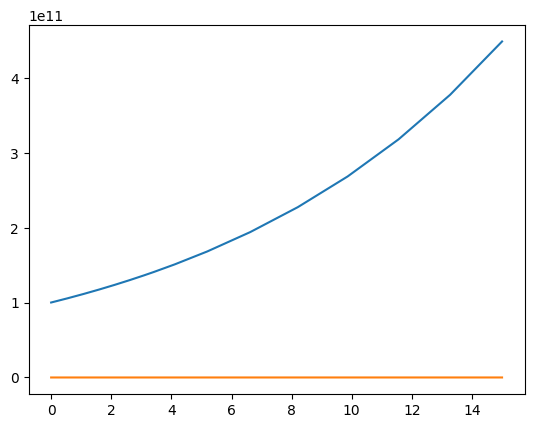

In [7]:
print(result.y_history)
import matplotlib.pyplot as plt

plt.plot(result.t_history, result.y_history.T)

# Rescue mutant

In [ ]:
seed = None
if seed is not None:
    rng = np.random.default_rng(seed)
else:
    rng = np.random.default_rng()

y0 = np.array([
    10e8, # target cells
    10e1,  # wildtype infected cells
    0,     # mutant infected cells
])

# it's more natural to think about the columns — because they are reactions — and then transpose
N = np.array([
    [0,-1,0], # death of wildtype
    [0,0,-1], # death of mutant
    [-1,1,0], # infection --> new wildtypes (by wildtype)
    [-1,0,1], # infection --> mutation into mutant (by wildtype)
    [-1,0,1], # infection --> new mutants
]).T

rate_involvement_matrix = np.array([
    [0,1,0],
    [0,0,1],
    [1,1,0],
    [1,1,0],
    [1,0,1],
]).T

R0 = 0.8   # wildtype is dying out
d  = 10    # death rate for wild type per day
beta = R0 * d / (y0[0]) # beta derived from above two
mu = 0.001 # rare mutations can save it
dmu = 2 # mutant dies less
Rmu = beta * y0[0] / dmu
assert np.isclose(Rmu, R0 * d/dmu) # Rmu should be x times bigger where x is d/dmu

def rescue_probability(R0, Rmu, mu, y0):
    return 1 - np.exp((mu*R0*(1-1/Rmu)*y0[1])/(R0-1))

def k_of_t(t):
    return [d, dmu, beta, beta*mu, beta]

1 - rescue_probability(R0, Rmu, mu, y0)

In [ ]:
extinctions = 0
for i in range(1000):
    result = forward_time(y0, [0, 15.0], lambda p: partition_by_threshold(p, 1000), k_of_t, N, rate_involvement_matrix, rng)
    extinctions += result.y[-1] == 0.0
    print("i", i, "Exctinctions:", extinctions, "extinction probability:", extinctions/i)
print("Expected extinction probability:", 1-rescue_probability(R0, Rmu, mu, y0))